In [1]:
import numpy as np

from tqdm.auto import tqdm
import os 
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import torch
from torchvision.models import mobilenet_v3_small
from torchvision import transforms as T
from PIL import Image
import torch
import random
import pandas as pd
import os
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split

import torch.nn.functional as F
import torch.optim as optim
from torch import nn

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
import zipfile
import os

# Пути к файлам
zip_file_path = 'data.zip'
extract_to = 'data/'

# Распаковка архива
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

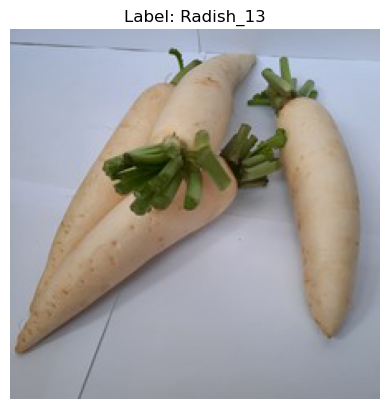

In [6]:
def show_image(dataset, index):
    image, label = dataset[index]
    plt.imshow(image)
    plt.title(f'Label: {dataset.classes[label]}')
    plt.axis('off')
    plt.show()

# Пример использования функции для отображения изображения
random_index = random.randint(0, len(train_dataset) - 1)
show_image(train_dataset, random_index)

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
dataset = datasets.ImageFolder(
    os.path.join('data', "train"),
    data_transforms["train"],
)

train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

In [4]:
train_simple_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
val_simple_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, pin_memory=True, num_workers=4)

In [39]:
train_set, val_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)
train_simple_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
val_simple_dataloader = DataLoader(val_set, batch_size=256, shuffle=False, pin_memory=True, num_workers=4)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [5]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [44]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights.IMAGENET1K_V1
num_epochs=3
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

C:\Users\Stepan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Stepan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:04<00:00, 10.4MB/s]


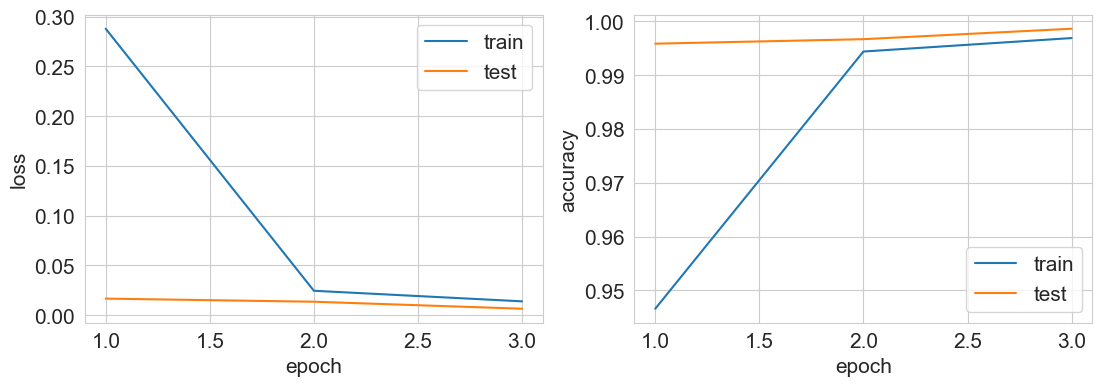

In [45]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_simple_dataloader, val_simple_dataloader, num_epochs
)

In [56]:
from torchvision.models import resnet50, ResNet50_Weights
model = models.resnet18()

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))
num_epochs=10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

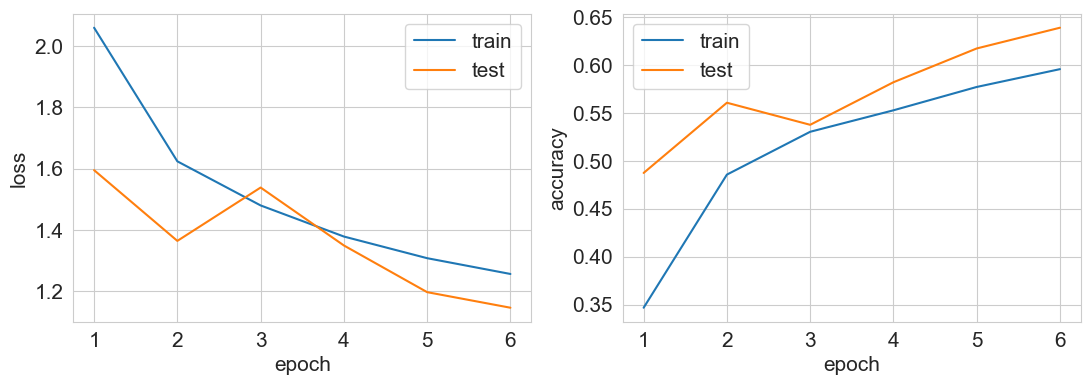

Training 7/10:   0%|          | 0/450 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_simple_dataloader, val_simple_dataloader, num_epochs
)

In [67]:
from torchvision.models import ResNet18_Weights
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))
num_epochs=10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

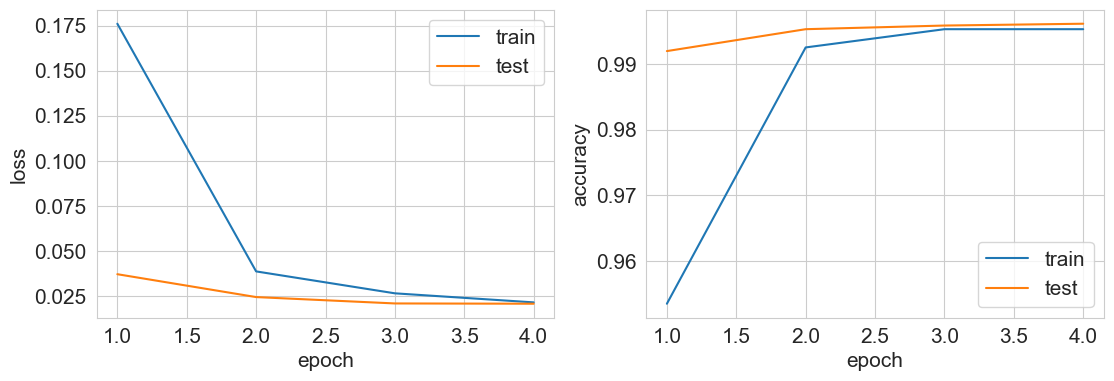

KeyboardInterrupt: 

In [69]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_simple_dataloader, val_simple_dataloader, num_epochs
)

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = sorted(all_imgs, key=lambda x: int(x.split(".")[0]))

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [7]:
test_dataset = CustomImageDataset(os.path.join('data', "test"), transform= data_transforms['val'])
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False,num_workers=2)

train_dataset = datasets.ImageFolder(os.path.join('data', "train"), transform=data_transforms['train'])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)


In [8]:
def train(model, optimizer, scheduler, criterion, train_loader, num_epochs):
    train_losses, train_accuracies = [],[]

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
    
    return train_losses, train_accuracies

In [11]:
from torchvision.models import ResNet18_Weights
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
num_epochs=10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [12]:
train_losses, train_accuracies = train(
    model, optimizer, scheduler, criterion, train_dataloader, num_epochs
)

Training 1/10:   0%|          | 0/563 [00:00<?, ?it/s]

Training 2/10:   0%|          | 0/563 [00:00<?, ?it/s]

Training 3/10:   0%|          | 0/563 [00:00<?, ?it/s]

Training 4/10:   0%|          | 0/563 [00:00<?, ?it/s]

Training 5/10:   0%|          | 0/563 [00:00<?, ?it/s]

Training 6/10:   0%|          | 0/563 [00:00<?, ?it/s]

Training 7/10:   0%|          | 0/563 [00:00<?, ?it/s]

Training 8/10:   0%|          | 0/563 [00:00<?, ?it/s]

Training 9/10:   0%|          | 0/563 [00:00<?, ?it/s]

Training 10/10:   0%|          | 0/563 [00:00<?, ?it/s]

In [13]:

model.eval()
predictions = []

for inputs in test_dataloader:
    inputs = inputs.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    predictions.append(preds.cpu().numpy())

print(predictions[:5])

[array([ 5, 11,  4, 13,  3, 12,  5,  4, 11, 11,  0, 10, 13, 12, 13, 12]), array([ 1, 14, 11,  6,  3, 14, 10,  6,  8,  0,  5, 12,  9,  6,  4, 14]), array([11, 11,  3, 14,  0,  0, 14,  0,  7,  4, 10, 12, 10,  1, 10,  6]), array([ 1, 11,  0, 14,  8, 14, 12,  6,  0, 13, 12,  5, 14,  7, 12,  5]), array([11, 13,  8,  4,  4, 10,  5, 14, 14, 11, 10,  2,  5, 14, 12, 11])]


In [23]:
predictions = np.concatenate([arr for arr in predictions])

In [24]:
ans = pd.DataFrame(predictions, columns=["prediction"])
ans.index.name = "id"
ans.to_csv("try1.csv", index=True) 